In [26]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import scipy.stats as sts
import sys
import os

%matplotlib inline

In [2]:
county_data = pd.read_csv(os.path.realpath("./Data/us_county.csv"))
covid_county_data = pd.read_csv(os.path.realpath("./Data/covid_us_county.csv")).filter(items=["county","state_code","lat","long",
                                                                                                 "date","cases"])
county_pop = pd.read_csv(os.path.realpath("./Data/us_county.csv"))
county_pop = county_pop.sort_values(by="population")

In [3]:
# load in the data
covid_county_data = covid_county_data[(covid_county_data["date"] <= "2020-12-31")]
print(covid_county_data.shape)
covid_county_data.head(5)

(1152990, 6)


,county,state_code,lat,long,date,cases
0,Autauga,AL,32.539527,-86.644082,2020-01-22,0
1,Autauga,AL,32.539527,-86.644082,2020-01-23,0
2,Autauga,AL,32.539527,-86.644082,2020-01-24,0
3,Autauga,AL,32.539527,-86.644082,2020-01-25,0
4,Autauga,AL,32.539527,-86.644082,2020-01-26,0


# Explain the data
# Discuss some basic findings (first cases date distribution, total case counts distribution, case count proportions by county, correlation between case proportion size and population size?)

In [4]:
np.random.seed(101)

#choose 20 counties to look at, can we find the best parameters for predicting their spread
county_index = list(sts.randint.rvs(low=1,high=county_pop.shape[0]-2,size=19)) + [county_pop.shape[0]-1]
county_index.sort()
counties_to_investigate = county_pop.iloc[county_index,:]
counties_to_investigate

,fips,county,state,state_code,male,female,median_age,population,female_percentage,lat,long
261,8033,Dolores County,Colorado,CO,989,852,51.8,1841,46.279196,37.751712,-108.517400
2531,48017,Bailey County,Texas,TX,3640,3452,33.5,7092,48.674563,34.068578,-102.829874
2690,48335,Mitchell County,Texas,TX,5383,3175,34.1,8558,37.099790,32.306202,-100.921138
1569,29173,Ralls County,Missouri,MO,5178,5039,45.0,10217,49.319761,39.527685,-91.522031
1023,21061,Edmonson County,Kentucky,KY,6093,6029,43.8,12122,49.736017,37.208799,-86.238422
398,13023,Bleckley County,Georgia,GA,5937,6838,36.8,12775,53.526419,32.434445,-83.327814
1593,29223,Wayne County,Missouri,MO,6544,6764,47.3,13308,50.826570,37.112647,-90.461405
2133,40005,Atoka County,Oklahoma,OK,7306,6568,40.6,13874,47.340349,34.373729,-96.037824
770,18147,Spencer County,Indiana,IN,10363,10163,43.6,20526,49.512813,38.014096,-87.007670
3040,54097,Upshur County,West Virginia,WV,12200,12405,42.0,24605,50.416582,38.897844,-80.233441


In [27]:
def q_split(cty):
    return str(cty).rsplit()[0]

counties_to_investigate["county"] = counties_to_investigate.county.apply(q_split)
counties_to_investigate.iloc[19,1] = "Los Angeles"

In [6]:
#first need function to calc diff only if condition met

def ret_bool(cell):
    
    if cell < 0:
        return(0)
    else:
        return(cell)
    
## inner join investigate with daily cases data to filter on counties of interest
counties_filter = counties_to_investigate.merge(covid_county_data,on=["county","state_code"]).iloc[:,[1,2,7,13,14]]
counties_filter["daily_diff"] = [0]+list(np.array(counties_filter.cases[1:counties_filter.shape[0]])-np.array(counties_filter.cases[0:(counties_filter.shape[0]-1)]))

#find the first day with more than 1 case across all cities
cases_temp = pd.Series(counties_filter.sort_values("date").reset_index().cases > 0)
cases_temp = cases_temp[cases_temp].index[0]

#date at that point
date_start = counties_filter.sort_values("date").date.iloc[cases_temp]

#filter from that point on
counties_filter = counties_filter.sort_values("date").reset_index()
counties_filter = counties_filter[counties_filter.date >= date_start]
counties_filter = counties_filter.sort_values(by=["county","date"]).reset_index().iloc[:,[2,3,5,6,7]]

#deal with new cities every once in awhile
counties_filter["daily_diff"] = counties_filter["daily_diff"].apply(ret_bool)

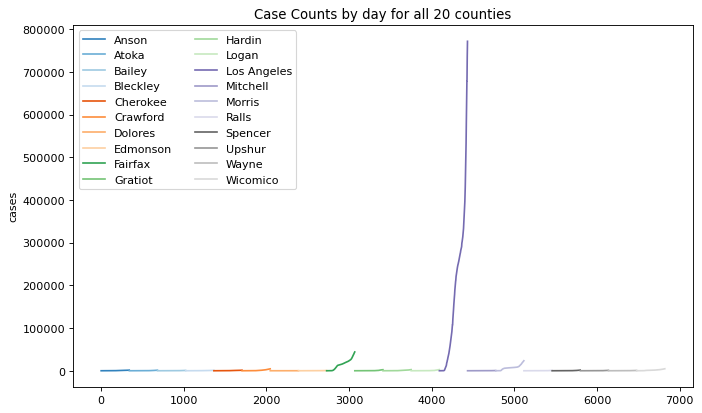

In [7]:
### make some plots, first we can look at the time series of cases for each county


#for each county, filter df and add a line plot. loop through the colormap too to assign colors to each line
#need to creat the ax, fig objects to add the line plots to
figure(figsize=(10, 6), dpi=80)
case_plot = sns.lineplot(data=counties_filter,hue="county",palette="tab20c",x=range(0,counties_filter.shape[0]),y="cases",
                        legend=True)
plt.title("Case Counts by day for all 20 counties")
plt.legend(loc="upper left",ncol=2)

# CHANGE THE BELOW FIGURE TO HISTOGRAMS FOR EACH COUNTY

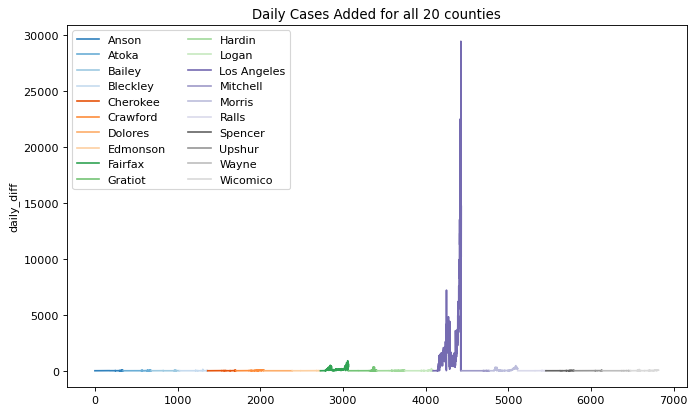

In [8]:
## create ax and figure object and add each dataset to the plot one-by-one.
## index should hopefully be the same for each county
figure(figsize=(10, 6), dpi=80)

case_diff_plot = sns.lineplot(data=counties_filter,hue="county",palette="tab20c",x=range(0,counties_filter.shape[0]),y="daily_diff",
                        legend=True)
plt.title("Daily Cases Added for all 20 counties")
plt.legend(loc="upper left",ncol=2)



# daily difference distributions after first case reported for each county

- Step through generations 1:n, start with $X(0)=1$ and store the P(#children for each)
    - At each step, generate k for each child in the simulation
    - Take the source found for "infective period" and assign a value to each "child" in the model
         - Each child can be track with a unique ID I think, we will discretize this to be contagious for 1,2,3,... days and each day they are infected they can create children.
         
    * At each generation, the k values drawn are independent and therefore represent the number of **new simulated cases** at day *n*
    * At each generation, the sum of *X(n)* + *X(n-1)* + ... + X(0) are the total number of simulated cases
    * Expectations and variances for each generation can be generated using P. 87 from the text
    * Going to need to look into fitting time series data

<font size=36> **The simulation** </font>

In [9]:
## all counties in dataframe and find the first day that a case was recorded for the chosen county
## will loop over all counties next and produce a visual to see possible fit
all_counties = counties_filter.county.unique()
all_counties


def branch_sim(params,county,dates,num_days_to_sim=100):
    x0 = 1 # this could change for each county?
    gen = 0 #gen 0 is day 1

    X_n = {} #key is generation (date), value is number from binomial random draw

    #test_df  = counties_filter.iloc[first_case:first_case+num_days_to_sim,:]
    dates_of_sim = dates

    #n, p = (5,.21) #bounding to avoid unwieldy numbers
    #n, p = (5,((4**(1/100))/5)) #bounding to avoid unwieldy numbers
    n, p = params
    all_series = {}
    for runs in range(0,1000):

        for g in range(gen,num_days_to_sim):

            if g == 0:
                X_n[dates_of_sim.iloc[g]] = [x0]
                kids = sum(X_n[dates_of_sim.iloc[g]])

            else:
                #for every parent, generate number of children from binomial
                parents = sum(X_n[dates_of_sim.iloc[g-1]])
                if parents > 0:
                    X_n[dates_of_sim.iloc[g]] = list(sts.binom.rvs(n=n,p=p,size=parents)) #gen children for each parent
                    kids = X_n[dates_of_sim.iloc[g]]
                else:
                    X_n[dates_of_sim.iloc[g]] = [0]

                

        all_series[str(runs+1)] = [sum(tots) for tots in X_n.values()]   #iterate through lists at each gen and sum, store for df     
        X_n = {}

    df_of_sims = pd.DataFrame.from_dict(all_series)
    df_of_sims["Expected_Sim"] = df_of_sims.mean(axis=1)
    df_of_sims.index = dates
    return(df_of_sims)


In [10]:
fun_test = branch_sim(params=(5,.21),county=all_counties[4],dates=pd.Series(range(0,100)))
fun_test.tail()

,1,2,3,4,5,6,7,8,9,10,...,992,993,994,995,996,997,998,999,1000,Expected_Sim
95,533,0,0,0,0,0,0,1487,0,0,...,0,0,0,0,0,137,455,166,0,90.387
96,540,0,0,0,0,0,0,1577,0,0,...,0,0,0,0,0,158,473,171,0,94.715
97,551,0,0,0,0,0,0,1653,0,0,...,0,0,0,0,0,184,487,196,0,99.540
98,571,0,0,0,0,0,0,1795,0,0,...,0,0,0,0,0,197,522,203,0,104.510
99,631,0,0,0,0,0,0,1942,0,0,...,0,0,0,0,0,200,531,224,0,109.382


Text(0.5, 1.0, '1000 Simulations of  Binomial Branching Process: $\\mathbf{n=5},\\mathbf{p=.21}$')

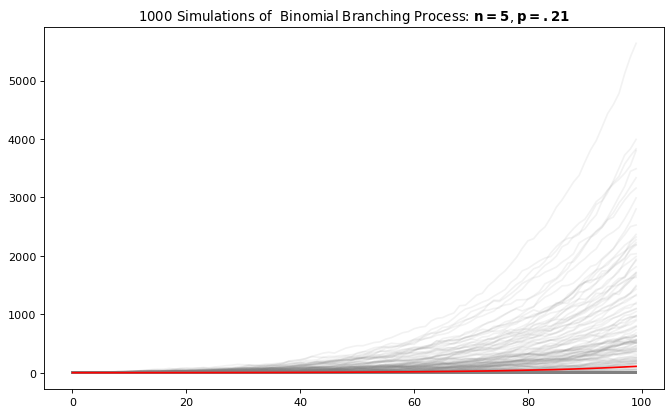

In [11]:
fig = figure(figsize=(10, 6), dpi=80)

ax = fig.add_subplot()

fun_test.loc[:,fun_test.columns != "Expected_Sim"].plot(legend=False,c="gray",alpha=.1,ax=ax)
fun_test.loc[:,fun_test.columns == "Expected_Sim"].plot(legend=False,c="red",alpha=1,ax=ax)
## how to use a variable in the string? str.format or something
plt.title("1000 Simulations of  Binomial Branching Process: $\mathbf{n=5},\mathbf{p=.21}$")

# call the branch sim function for each county and plot the fitted branch sim against the actual daily case counts
   ### - for each county, need number of new cases on day $n$, in order to find the $p$ for the branch sim call
   ### - each county will have daily case counts plot. same index for each

## one plot per county, stats to look at would be the sum of squared residuals and the RMSE of the observations by day (table for these, maybe only a few plots)

## the so what???


### lastly will be to predict into the future 
#### - the model here is a linear fit using only the expected value for the distribution based on the observed cases at day n
#### - we can use this value as the input to the simulation, and use that returned simulated value as the predictor of the next day + to see how the model performs for each county
         - another option could be a moving average of the simulations for prediction

In [25]:
counties_filter.head()

,county,state,date,cases,daily_diff
0,Anson,North Carolina,2020-01-26,0,0
1,Anson,North Carolina,2020-01-27,0,0
2,Anson,North Carolina,2020-01-28,0,0
3,Anson,North Carolina,2020-01-29,0,0
4,Anson,North Carolina,2020-01-30,0,0


In [12]:
#plotting function for each county

def pplot(df,county,fig):
    
    cols_to_plot = ["Expected_Sim","Expected_Theory","daily_cases"]
    
    df[df.columns.intersection(cols_to_plot)].plot()
    fig.add_subplot()
    plt.title("Fitted Simulation, Theoretical Branching Process Overlaid with\n "+county+" Daily Case Recordings")


In [42]:
## function for iterating through the counties and simulating a branching process then storing the actual spread
## with the expected counts based on the nth day

# branch_sim()
### @param: n,p for binomial distribution
### @param: county name
### @param: number of days to simulate

def county_branch(county,model):
    
    print("Simulating and storing for: "+county)
    num_days_to_sim = 100
    num_days_to_forecast = 30
    
    first_case = pd.Series(counties_filter[counties_filter.county==county].cases > 0)
    first_case = first_case[first_case].index[0]
    
    temp_df = counties_filter.iloc[first_case:first_case+num_days_to_sim,:]
    dates_of_sim = temp_df.date
    
    temp_forecast = counties_filter.iloc[first_case:first_case+num_days_to_sim+num_days_to_forecast,:]
    
    ## find p
    n = 5
    if model == "nth day":
        #mu based on 100th day cases, what if i took average cases instead
        mu = temp_df.iloc[99,4]**(1/num_days_to_sim)
        p = mu / n
    elif model == "sample average":
        mu = np.mean(temp_df.daily_diff)**(1/num_days_to_sim)
        p = mu / n
    else:
        mu = np.mean(temp_df.daily_diff[num_days_to_sim-7:])**(1/num_days_to_sim)
        p = mu / n
    
    params = (n,p)
    
    forecast_df = counties_filter.iloc[first_case:first_case+num_days_to_sim+num_days_to_forecast,:]
    forecast_df["Expected_Theory"] = np.array([1]+[mu**n for n in range(1,num_days_to_sim+num_days_to_forecast)])
    forecast_df["Sq_Er"] = (forecast_df.Expected_Theory - forecast_df.daily_diff)**2
    forecast_df.index = np.array(range(0,num_days_to_sim+num_days_to_forecast))
    
    county_df = branch_sim(params=params,county=county,dates=dates_of_sim,num_days_to_sim=num_days_to_sim)
    county_df["daily_cases"] = temp_df.daily_diff.values #add daily counts to end for plotting
    county_df["Expected_Theory"] = np.array([1]+[mu**n for n in range(1,num_days_to_sim)])
    county_df["Sq_Er"] = (county_df.Expected_Theory - county_df.daily_cases)**2
    county_df.index = dates_of_sim

    county_RMSE = np.sqrt(np.sum(county_df.Sq_Er)/num_days_to_sim)
    return((county_df,forecast_df,mu,county_RMSE))

## call for each county and produce a plot with the branching sim and the
## actual daily differences for the paper

##### need to store the outputs, and the expected value of the distribution for each.
######### will use the expected value to predict into the future
############### this number would be an anticipated case additions if no preventative measures are put into place

output_analyze_nth = {}
output_analyze_mean = {}
output_analyze_seven = {}

for county in all_counties:
    
    # store the data frame, mu for that county
    output_analyze_nth[county] = county_branch(county,model="nth day")
    output_analyze_mean[county] = county_branch(county,model="sample average")
    output_analyze_seven[county] = county_branch(county,model="seven")

Simulating and storing for: Anson
Simulating and storing for: Anson
Simulating and storing for: Anson
Simulating and storing for: Atoka
Simulating and storing for: Atoka
Simulating and storing for: Atoka
Simulating and storing for: Bailey
Simulating and storing for: Bailey
Simulating and storing for: Bailey
Simulating and storing for: Bleckley
Simulating and storing for: Bleckley
Simulating and storing for: Bleckley
Simulating and storing for: Cherokee
Simulating and storing for: Cherokee
Simulating and storing for: Cherokee
Simulating and storing for: Crawford
Simulating and storing for: Crawford
Simulating and storing for: Crawford
Simulating and storing for: Dolores
Simulating and storing for: Dolores
Simulating and storing for: Dolores
Simulating and storing for: Edmonson
Simulating and storing for: Edmonson
Simulating and storing for: Edmonson
Simulating and storing for: Fairfax
Simulating and storing for: Fairfax
Simulating and storing for: Fairfax
Simulating and storing for: Gra

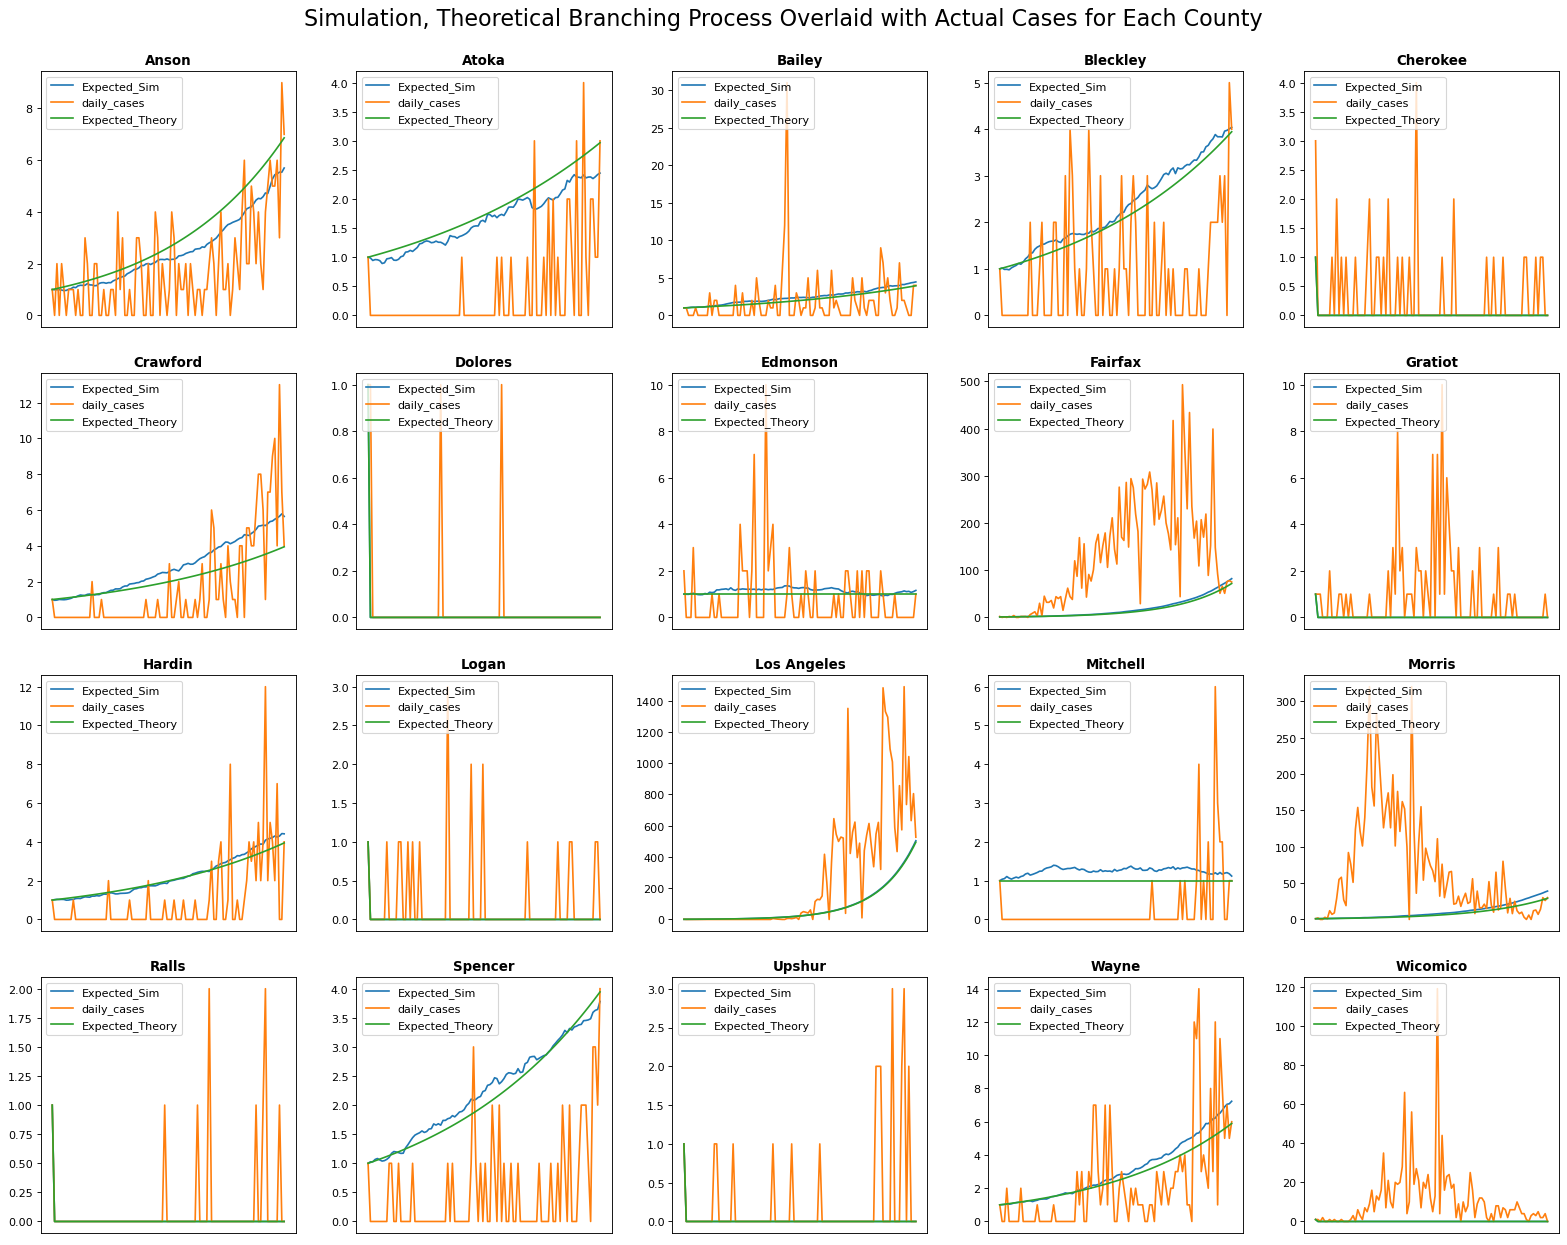

In [16]:
## calculate RMSE for training set, then try to predict n+1,n+2,n+...,n+30 days into future. 

def plot_fits(dct,predict):
    
    if not predict:
        index = 1
        fig = figure(figsize=(20, 16), dpi=80)
        cols_to_plot = ["Expected_Sim","Expected_Theory","daily_cases"]

        for c, data in dct.items():

            df = data[0]
            ax = fig.add_subplot(4,5,index)
            index += 1

            fig.suptitle("Simulation, Theoretical Branching Process Overlaid with Actual Cases for Each County",fontsize=20)
            df[df.columns.intersection(cols_to_plot)].plot(ax=ax)
            plt.title(c,fontsize="large",fontweight="bold")
            plt.legend(loc="upper left")
            plt.xticks([])
            plt.xlabel("")
    else:
        index = 1
        fig = figure(figsize=(20, 16), dpi=80)
        cols_to_plot = ["Expected_Sim","Expected_Theory","daily_cases"]
        
        for c, data in dct.items():

            df = data[1]
            ax = fig.add_subplot(4,5,index)
            index += 1

            fig.suptitle("Predicting 30 days into the future with the Underlying Branching Process Model",fontsize=20)
            df[df.columns.intersection(cols_to_plot)].plot(ax=ax)
            plt.title(c,fontsize="large",fontweight="bold")
            plt.legend(loc="upper left")
            plt.xticks([])
            plt.xlabel("")
    plt.tight_layout(pad=2.2)

## add RMSE for each county to the stored dictionary
plot_fits(output_analyze_nth,predict=False)

# next we want to simulate with branching process function using 2 new values of mu. 

   - first is mu is average of all cases over 100 days
   - second is mu is average of all cases over last week

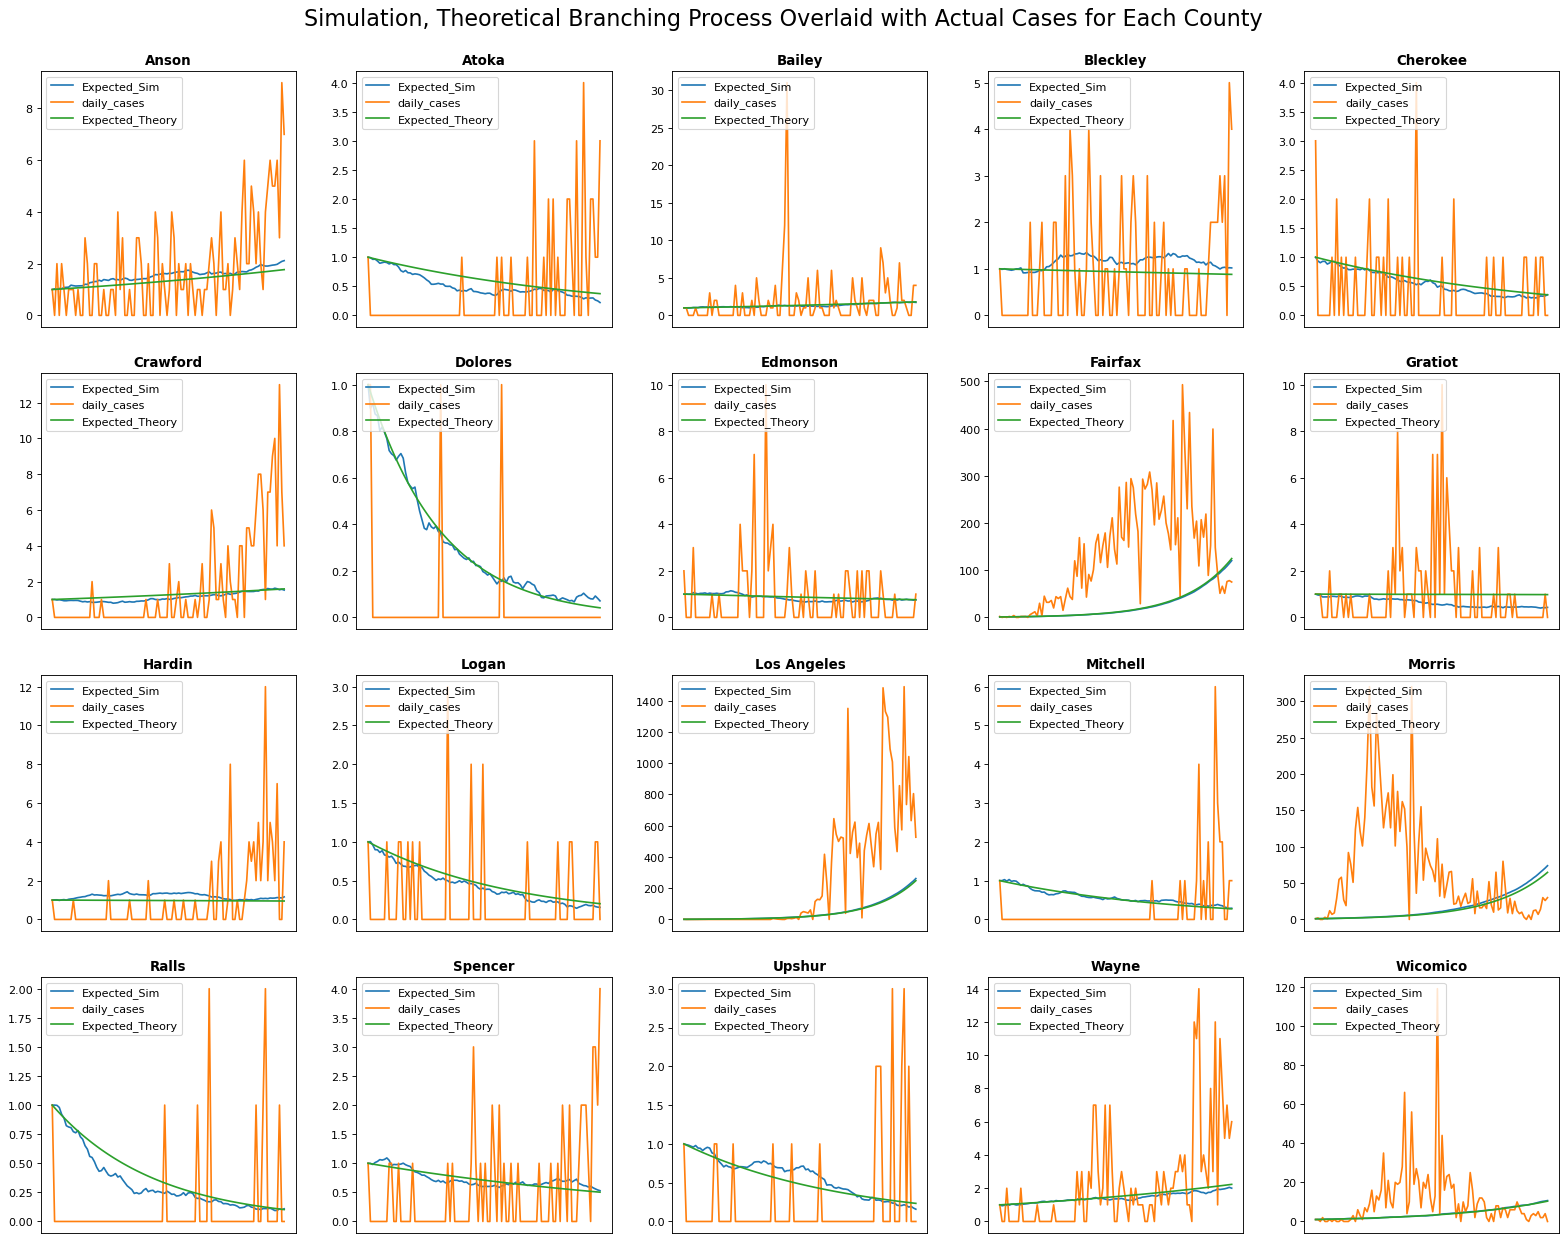

In [17]:
plot_fits(output_analyze_mean)

## for every county, look at probability of extinction and maybe the variance at day $n$

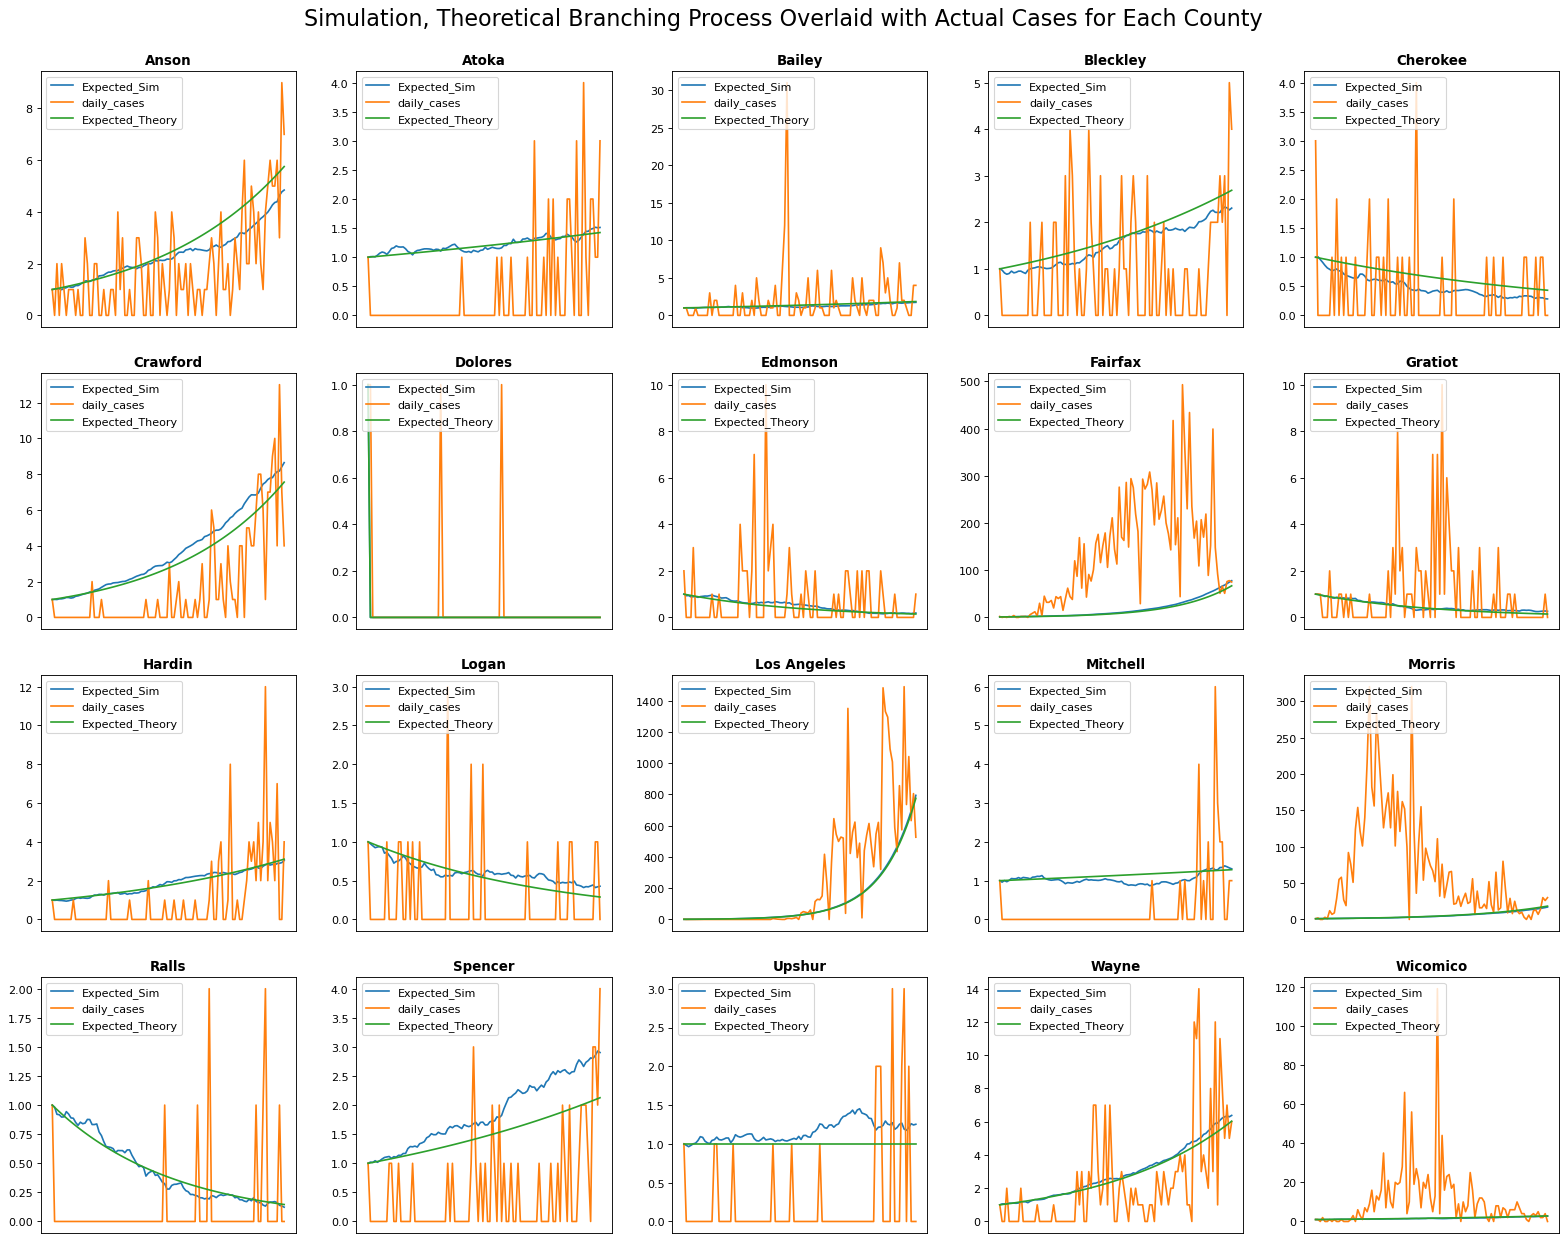

In [18]:
plot_fits(output_analyze_seven)

# dataframes should be ready now for predicting with the different underlying branching processes

In [45]:
## going to plot 1 of the models with predicitions.

#after that will summarize with RMSE for all models and every county

,county,state,date,cases,daily_diff,Expected_Theory,Sq_Er
90,Anson,North Carolina,2020-06-29,128,1,5.762199,22.678537
91,Anson,North Carolina,2020-06-30,132,4,5.875424,3.517215
92,Anson,North Carolina,2020-07-01,137,5,5.990874,0.981832
93,Anson,North Carolina,2020-07-02,143,6,6.108593,0.011792
94,Anson,North Carolina,2020-07-03,148,5,6.228625,1.509518
95,Anson,North Carolina,2020-07-04,153,5,6.351015,1.825242
96,Anson,North Carolina,2020-07-05,159,6,6.475810,0.226395
97,Anson,North Carolina,2020-07-06,162,3,6.603058,12.982026
98,Anson,North Carolina,2020-07-07,171,9,6.732806,5.140170
99,Anson,North Carolina,2020-07-08,178,7,6.865103,0.018197


# some analysis on the probability of extinction for each county given the value at the 100th day
# pgf for the distribution, solve that polynomial in python